In [1]:
import gerrychain
from gerrychain import (
    MarkovChain,
    constraints,
    accept
)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_seed_part, bipartition_tree
from functools import partial
from tqdm import tqdm
import pandas as pd
import os
import click
import random
from division_aware import *
import matplotlib.pyplot as plt
from utilities import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
graph = Graph.from_json("shapes/wisconsin2020_graph_cousub.json")
munis, nodes_by_muni = get_divisions(graph, "COUSUB")
counties, nodes_by_county = get_divisions(graph, "COUNTYFP")

In [11]:
def get_max_deviation(partition, ideal_pop):
    max_dev = max({d:abs(partition.population[d] - ideal_pop) / ideal_pop for d in partition.population.keys()}.values())
    return max_dev

In [41]:
POP_COL = "TOTPOP19"
epsilon = 0.02
steps = 500

def guided_acceptance_factory(ideal_pop):
    def accept_lower_deviation(partition):
        parent = partition.parent
        child_dev = get_max_deviation(partition, ideal_pop)
        parent_dev = get_max_deviation(parent, ideal_pop)
        probability = min([1*math.exp(100000*(parent_dev - child_dev)), 1])
        if random.random() < probability:
            return True
        else:
            return False
    return accept_lower_deviation

initial_partition = make_partition_from_districtr_csv("WI", graph, "WI1")
ideal_population = sum(initial_partition.population.values()) / len(initial_partition)

proposal = partial(recom,
                   pop_col=POP_COL,
                   pop_target=ideal_population,
                   epsilon=epsilon,
                   node_repeats=2)

elections = states["WI"]["elections"].keys()
acceptance = guided_acceptance_factory(ideal_population)

chain = MarkovChain(
                    proposal = proposal,
                    constraints = [constraints.within_percent_of_ideal_population(initial_partition, epsilon)],
                    accept = acceptance,
                    initial_state = lowest_dev_plan,
                    total_steps = steps)

In [42]:
max_devs = []
lowest_dev = None
lowest_dev_plan = None
for i, part in enumerate(chain.with_progress_bar()):
    max_dev = get_max_deviation(part, ideal_population)
    max_devs.append(max_dev)
    if lowest_dev is None or max_dev <= lowest_dev:
        lowest_dev_plan = part
        lowest_dev = max_dev

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Maximum Population Deviation')

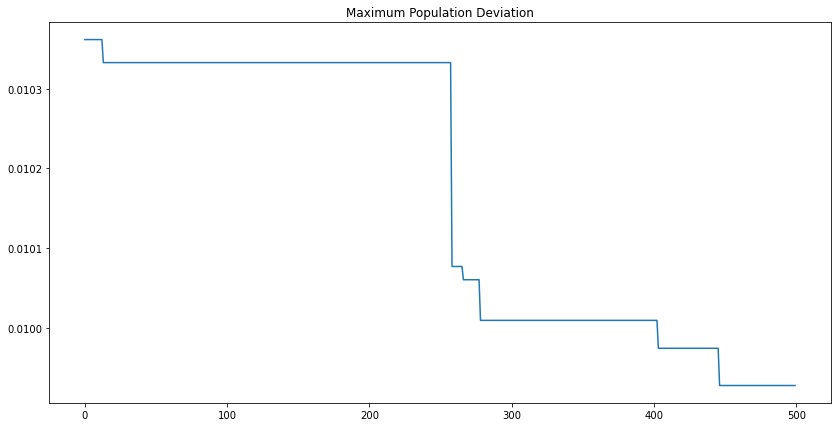

In [43]:
fig, ax = plt.subplots(1,1,figsize=(14,7))
plt.subplots_adjust(hspace=0.5)
ax.plot(max_devs)
ax.set_title("Maximum Population Deviation")

In [44]:
save_partition_as_districtr_csv(graph, lowest_dev_plan, 'Code-2', "WI_seed_1pct_plan")

In [45]:
lowest_dev

0.009927215524252296